# Lecture Radiographies poumons, recherche pneumonies virales ou bactériennes, VGG16 Fine Tuning partiel 06

## 0. Import des librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from pathlib import Path

2024-06-23 10:40:31.377289: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-23 10:40:31.616402: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 10:40:32.528759: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1. Paramétrage

In [2]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50  # Augmentation du nombre d'époques
CWD = Path.cwd()
NEW_TRAIN = CWD / "sorted_data" / "train"
NEW_VAL = CWD / "sorted_data" / "val"
NEW_TEST = CWD / "sorted_data" / "test"
class_names = {0: 'NORMAL', 1: 'VIRUS', 2: 'BACTERIA'}

## 2. Préparer les datasets avec augmentation des données

In [3]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.1,
    preprocessing_function=preprocess_input
)
train_dataset = train_datagen.flow_from_directory(
    directory=NEW_TRAIN,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_dataset = validation_datagen.flow_from_directory(
    directory=NEW_VAL,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_dataset = test_datagen.flow_from_directory(
    directory=NEW_TEST,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 12483 images belonging to 3 classes.
Found 288 images belonging to 3 classes.
Found 822 images belonging to 3 classes.


## 3. charger le modèle précédent my_model_finetuned_1.keras

In [4]:
model = load_model('my_model_finetuned_3.keras')

# Afficher les couches du modèle pour identifier la couche VGG16
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name}, {layer.__class__.__name__}")

2024-06-23 10:40:34.997823: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-23 10:40:35.107619: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Layer 0: input_layer_1, InputLayer
Layer 1: block1_conv1, Conv2D
Layer 2: block1_conv2, Conv2D
Layer 3: block1_pool, MaxPooling2D
Layer 4: block2_conv1, Conv2D
Layer 5: block2_conv2, Conv2D
Layer 6: block2_pool, MaxPooling2D
Layer 7: block3_conv1, Conv2D
Layer 8: block3_conv2, Conv2D
Layer 9: block3_conv3, Conv2D
Layer 10: block3_pool, MaxPooling2D
Layer 11: block4_conv1, Conv2D
Layer 12: block4_conv2, Conv2D
Layer 13: block4_conv3, Conv2D
Layer 14: block4_pool, MaxPooling2D
Layer 15: block5_conv1, Conv2D
Layer 16: block5_conv2, Conv2D
Layer 17: block5_conv3, Conv2D
Layer 18: block5_pool, MaxPooling2D
Layer 19: flatten_1, Flatten
Layer 20: flatten_3, Flatten
Layer 21: flatten, Flatten
Layer 22: dense, Dense
Layer 23: dropout, Dropout
Layer 24: dense_1, Dense
Layer 25: dropout_1, Dropout
Layer 26: dense_2, Dense


## 4. Dégeler les couches 10 à 18 du modèle importé

In [5]:
# Dégeler plus de couches de VGG16
for layer in model.layers[:10]:  # Geler les premières couches de 0 à 9
    layer.trainable = False

for layer in model.layers[10:19]:  # Dégeler les couches de 10 à 18
    layer.trainable = True

## 5. Ajouter des couches supplémentaires avec Dropout et régularisation L2

In [6]:
x = model.layers[20].output  # Faut prendre la dernière donc hmm Flatten_3 ?
x = Flatten(name='new_flatten')(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # 3 classeuh :D : NORMAL, BACTERIA, VIRUS

## 6. Recompiler le modèle avec un taux d'apprentissage plus faible

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall()])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,79

 Total params: 21,204,035 (80.89 MB)

 Trainable params: 19,468,547 (74.27 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

## 7. Ajout de l'early stopping et ajustement du taux d'apprentissage

In [8]:
# Callbacks pour l'entraînement
es = EarlyStopping(
    monitor="val_accuracy", 
    mode="max", 
    patience=15,  # Augmenter la patience
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  # Augmenter le facteur de réduction
    patience=3,
    min_lr=1e-6
)

## 8. Continuer l'entraînement

In [9]:
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, callbacks=[es, reduce_lr], shuffle=True)

Epoch 1/50


/home/neminounet/Documents/Epitech/T-DEV-810/EPI_DEV_810/env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 952s 2s/step - accuracy: 0.8419 - loss: 0.4576 - recall: 0.8360 - val_accuracy: 0.6840 - val_loss: 0.6313 - val_recall: 0.6701 - learning_rate: 1.0000e-04
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 933s 2s/step - accuracy: 0.8528 - loss: 0.4199 - recall: 0.8449 - val_accuracy: 0.6771 - val_loss: 0.7058 - val_recall: 0.6736 - learning_rate: 1.0000e-04
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 879s 2s/step - accuracy: 0.8559 - loss: 0.4095 - recall: 0.8505 - val_accuracy: 0.7083 - val_loss: 0.7142 - val_recall: 0.7014 - learning_rate: 1.0000e-04
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 876s 2s/step - accuracy: 0.8681 - loss: 0.3918 - recall: 0.8618 - val_accuracy: 0.7257 - val_loss: 0.7271 - val_recall: 0.7188 - learning_rate: 1.0000e-04
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 876s 2s/step - accuracy: 0.8890 - loss: 0.3355 - recall: 0.8864 - val_accuracy: 0.7292 - val_loss: 0.7303 - val_recall: 0.7292 - learning_rate: 5.0000e-05
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━

## 9. Évaluation du modèle

In [10]:
test_loss, test_accuracy, test_recall = model.evaluate(test_dataset)
print(f"Loss on test dataset: {test_loss}")
print(f"Accuracy on test dataset: {test_accuracy}")
print(f"Recall on test dataset: {test_recall}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8188 - loss: 0.5870 - recall: 0.8095
Loss on test dataset: 0.6340063214302063
Accuracy on test dataset: 0.8102189898490906
Recall on test dataset: 0.801703155040741


## 10. Sauvegarde du modèle

In [11]:
model.save('my_model_finetuned_4.keras')

## 11. Visualisation des courbes d'apprentissage

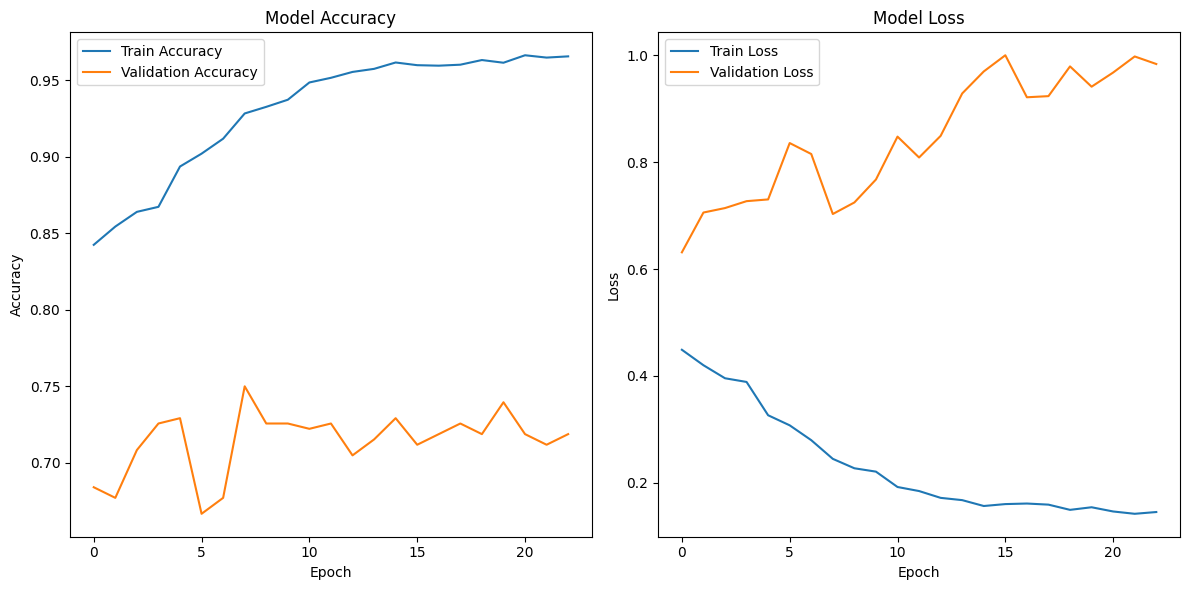

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()